# Analysis of product reviews in <i>/r/electronic_cigarette</i>
In this notebook we analyze product reviews found on <i>/r/electronic_cigarette</i>. The reviews were taken from the sub-reddit's wiki page. The wiki page is a community maintained encylopedia of the reddit; it contains a list of tutorials, and other content used by new comers.

There are 248 product reviews, each review on a different product.

In [1]:
import json
import numpy as np
import pyspark as spark
import pyspark.sql.functions as sfn
import pandas as pd
import plotly.offline as pty
import plotly.graph_objs as go
import spacy

from sklearn.manifold import TSNE
from types import SimpleNamespace

In [2]:
pty.init_notebook_mode()

In [3]:
sc = spark.SparkContext('local[*]')

In [4]:
ss = spark.sql.SparkSession(sc)

In [5]:
nlp = spacy.load('en')

## Loading the reviews
Let's have a brief look at the data we are using.

In [6]:
reviews = sc.textFile('../data/reviews.jl') \
    .map(lambda x: spark.sql.Row(**json.loads(x))) \
    .toDF()
reviews.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|           createdAt|         description|             product|          review_url|               title|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|Mon, 12 Nov 2018 ...|[specs -> [Dimens...|Husgsvape Surge Pod |https://www.reddi...|Anthony Vapes: Hu...|
|Mon, 03 Dec 2018 ...|[specs -> [Weight...|Havahalo Hava One...|https://www.reddi...|Anthony Vapes: Ha...|
|Fri, 07 Dec 2018 ...|[specs -> [Dimens...|      Voopoo Drag 2 |https://www.reddi...|Anthony Vapes: Vo...|
|Thu, 29 Nov 2018 ...|[specs -> [Six Ou...|Joyetech Ultex T8...|https://www.reddi...|Anthony Vapes: Jo...|
|Tue, 27 Nov 2018 ...|[specs -> [Dimens...|Innokin Endura T1...|https://www.reddi...|Anthony Vapes: In...|
|Wed, 28 Nov 2018 ...|[specs -> [Colors...| Smoant Campbel Kit |https://www.reddi...|Anthony Vapes: Sm...|
|Mon, 26 Nov 2018 ...|[specs -> [Dime

In [7]:
NUM_REVIEWS = reviews.count()
print(NUM_REVIEWS)

248


## Looking at the Pros and Cons
Each review comes with a list of pros and cons for the product. For example:

In [8]:
pros = reviews.select('review_url', sfn.explode('description.pros'))
pros.select('col').show(5, truncate=False)
pros = [SimpleNamespace(url=pro.review_url, statement=nlp(pro.col)) for pro in pros.collect()]

+-----------------------------+
|col                          |
+-----------------------------+
|color options (6 total)      |
|great 6ml capacity pods      |
|easily removable pods        |
|good build quality on battery|
|nice looks and paint job     |
+-----------------------------+
only showing top 5 rows



The total number of pros are:

In [9]:
len(pros)

2929

In [10]:
cons = reviews.select('review_url', sfn.explode('description.cons'))
cons.select('col').show(5, truncate=False)
cons = [SimpleNamespace(url=con.review_url, statement=nlp(con.col)) for con in cons.collect()]

+-----------------------------------------------------+
|col                                                  |
+-----------------------------------------------------+
|tinted pod is hard to see juice level                |
|Can’t judge inhale to fire since barely got to use it|
|coil life                                            |
|coil performance                                     |
|no Passthrough Vaping                                |
+-----------------------------------------------------+
only showing top 5 rows



The total number of cons are:

In [11]:
len(cons)

1003

In [12]:
def plot_tsne(reviews, title):
    plot_data = TSNE(n_components=2).fit_transform([review.statement.vector for review in reviews])
    trace = go.Scatter(
        x=plot_data[:, 0],
        y=plot_data[:, 1],
        mode='markers',
        text=[review.statement.text for review in reviews]
    )
    fig = go.Figure(data=[trace], layout=go.Layout(title=title))
    pty.iplot(fig)

In [13]:
plot_tsne(pros, 'Pros')

In [14]:
plot_tsne(cons, 'Cons')

## Topics discussed
We will now see what attribute/topics are discussed when describing a product's pros and cons.

In [13]:
from wordcloud import WordCloud
from collections import Counter
from itertools import combinations

def count_phrases(reviews, n=2, sequential=False):
    ngrams = []
    already_found = {}
    phrases = []
    for review in reviews:
        sentence = review.statement
        filtered_sent = list(filter(lambda x: not x.is_stop and not x.is_punct, sentence))
        if sequential:
            for i in range(len(filtered_sent) - n):
                ngram = frozenset([x.lemma_ for x in filtered_sent[i:i+n]])
                ngrams.append(ngram)
                if ngram not in already_found:
                    phrases.append(SimpleNamespace(
                        text='-'.join(ngram),
                        vector=np.average([x.vector for x in filtered_sent[i:i+n]], axis=0))
                    )
                else:
                    already_found.add(ngram)
        else:
            for combo in combinations(filtered_sent, n):
                ngram = frozenset([x.lemma_ for x in combo])
                ngrams.append(ngram)
                if ngram not in already_found:
                    phrases.append(SimpleNamespace(
                        text='-'.join(ngram),
                        vector=np.average([x.vector for x in combo], axis=0))
                    )
                else:
                    already_found.add(ngram)
    return {'-'.join(k):v for k, v in Counter(ngrams).items()}, phrases

import matplotlib.pyplot as plt
def create_wordcloud(freqDict, w=800, h=600):
    wc = WordCloud(width=w, height=h).generate_from_frequencies(freqDict)
    plt.figure(figsize=(30,30))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

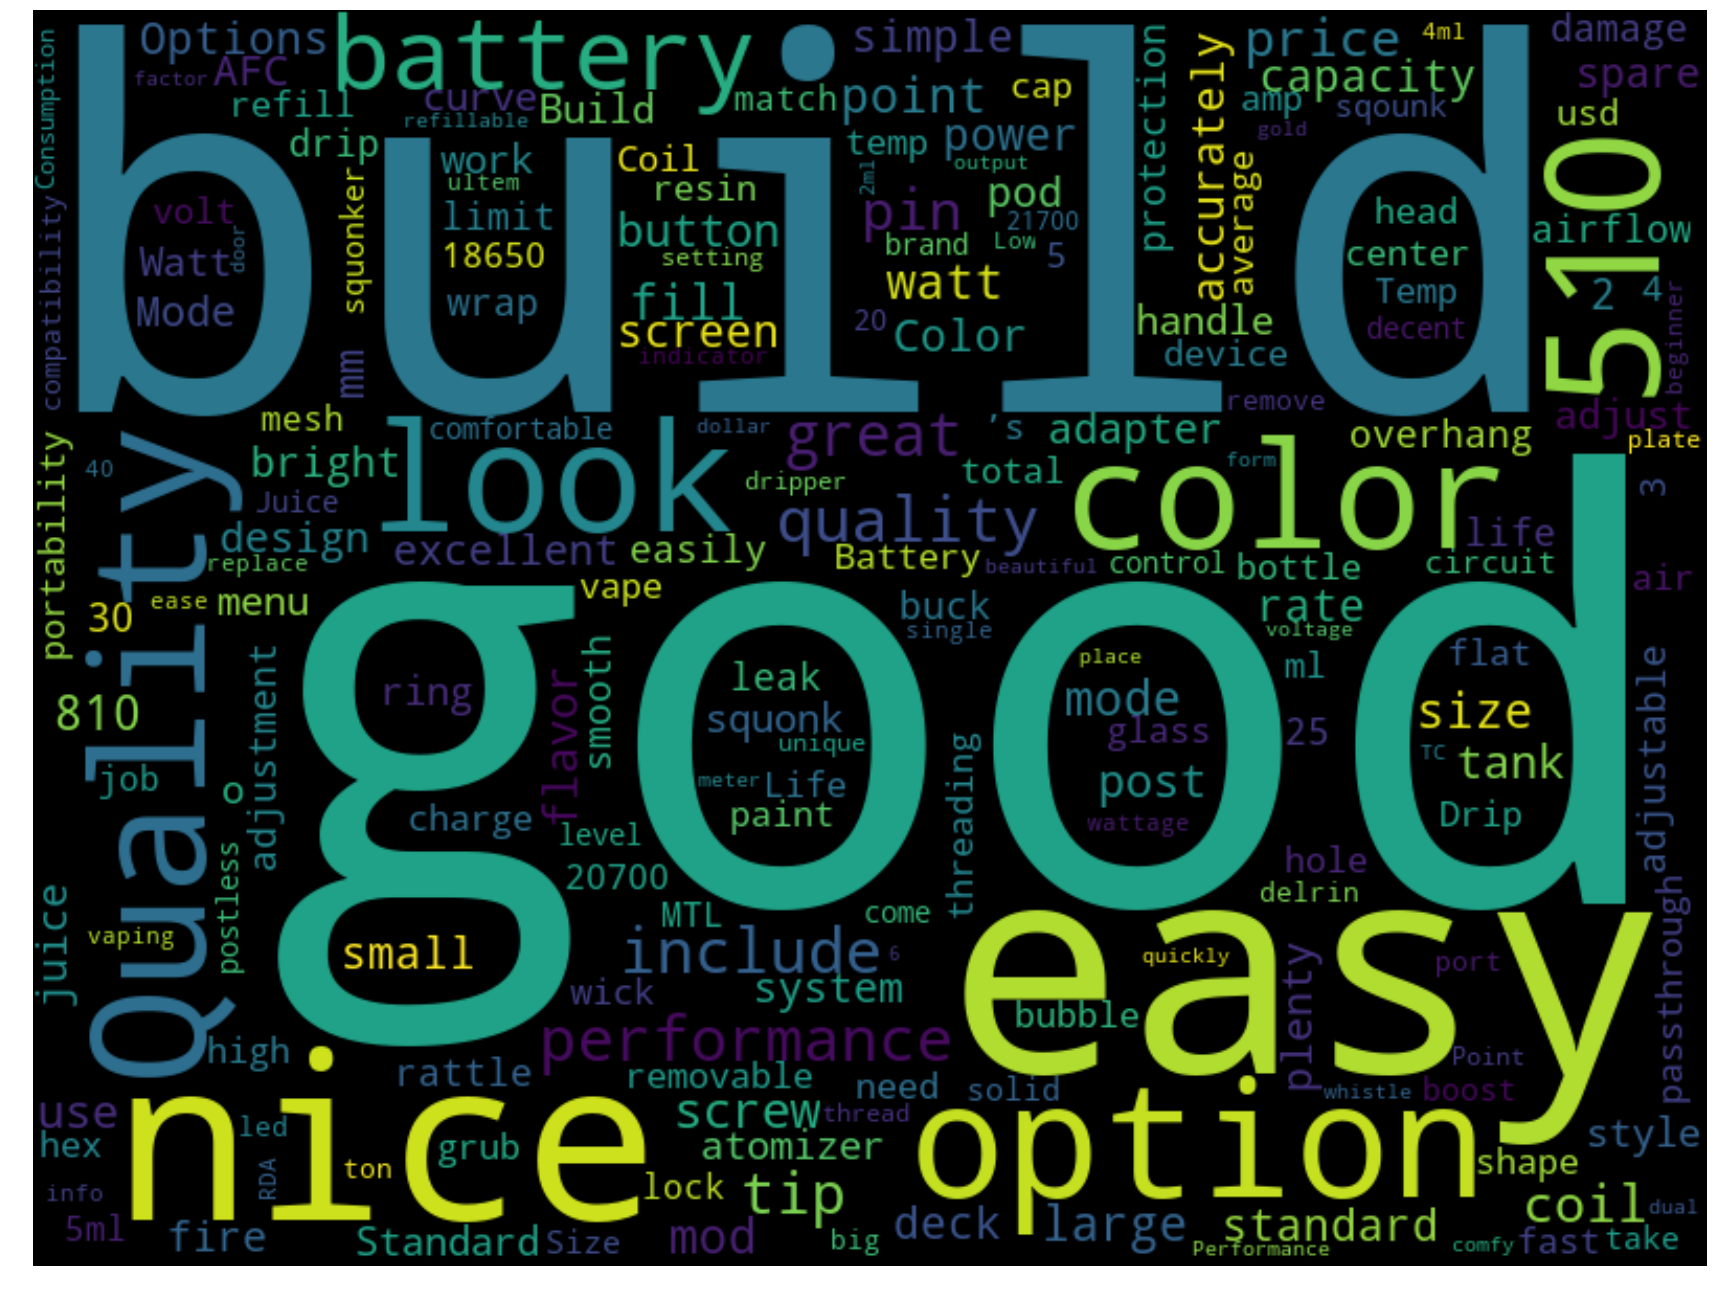

In [14]:
pros_phrases_uni = count_phrases(pros, 1)
create_wordcloud(pros_phrases_uni[0])

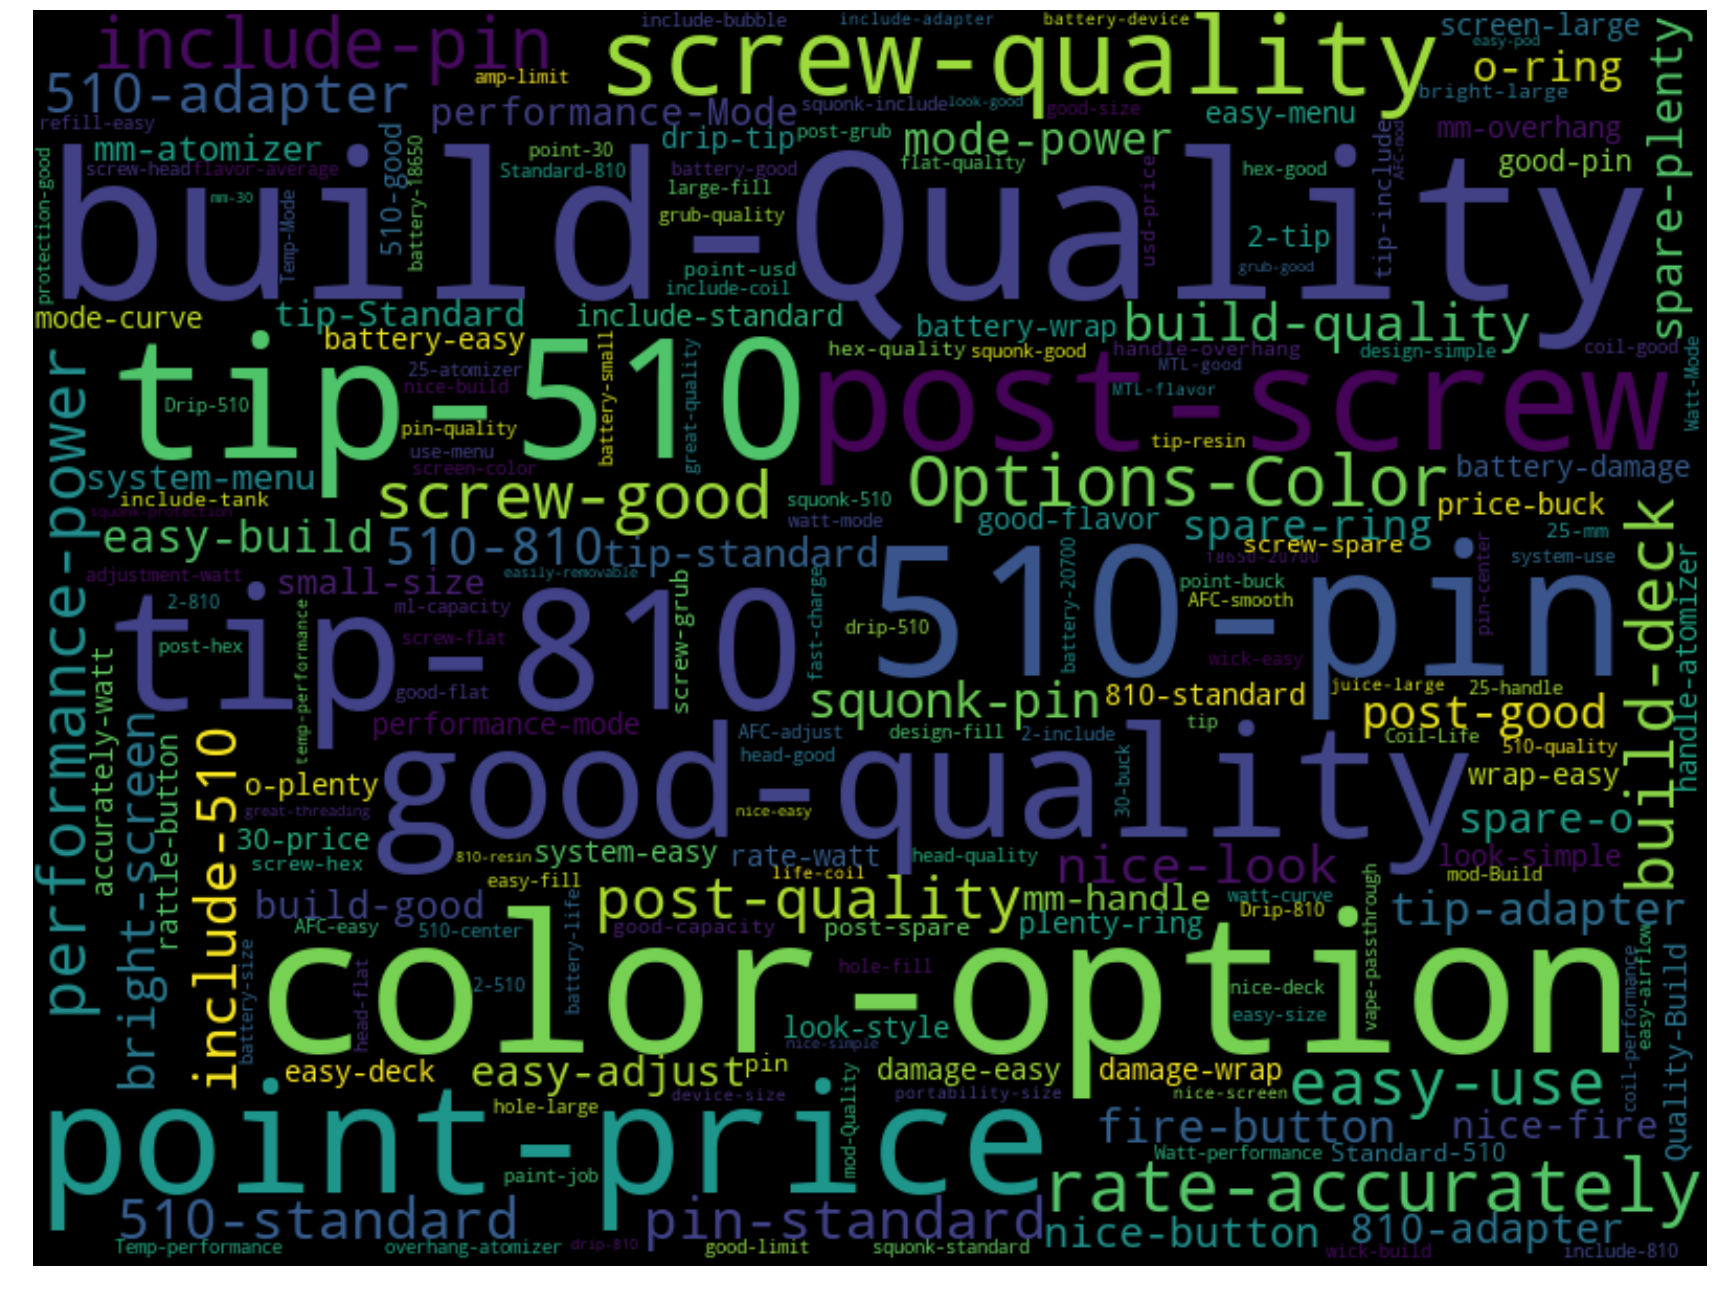

In [15]:
pros_phrases_bi = count_phrases(pros, 2)
create_wordcloud(pros_phrases_bi[0])

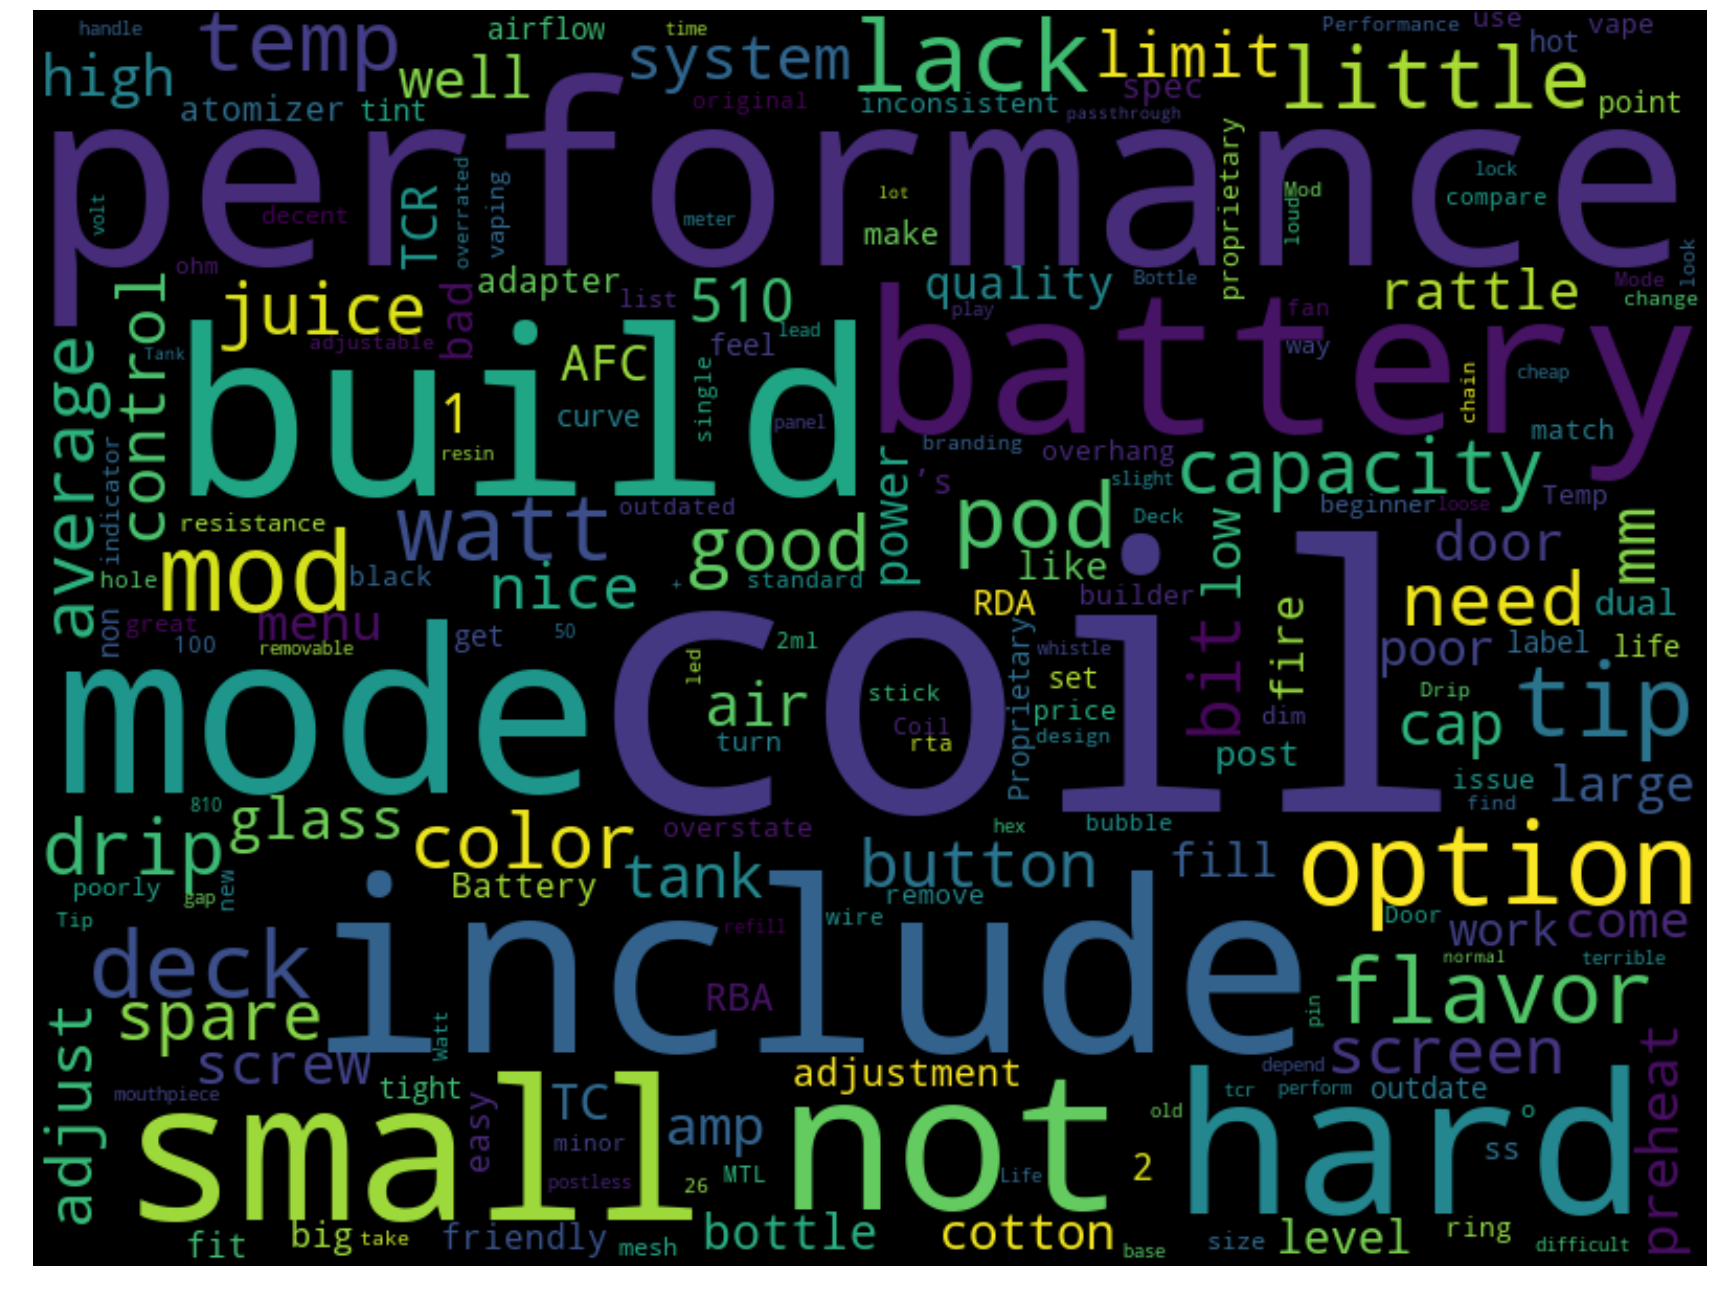

In [16]:
cons_phrases_uni = count_phrases(cons, 1)
create_wordcloud(cons_phrases_uni[0])

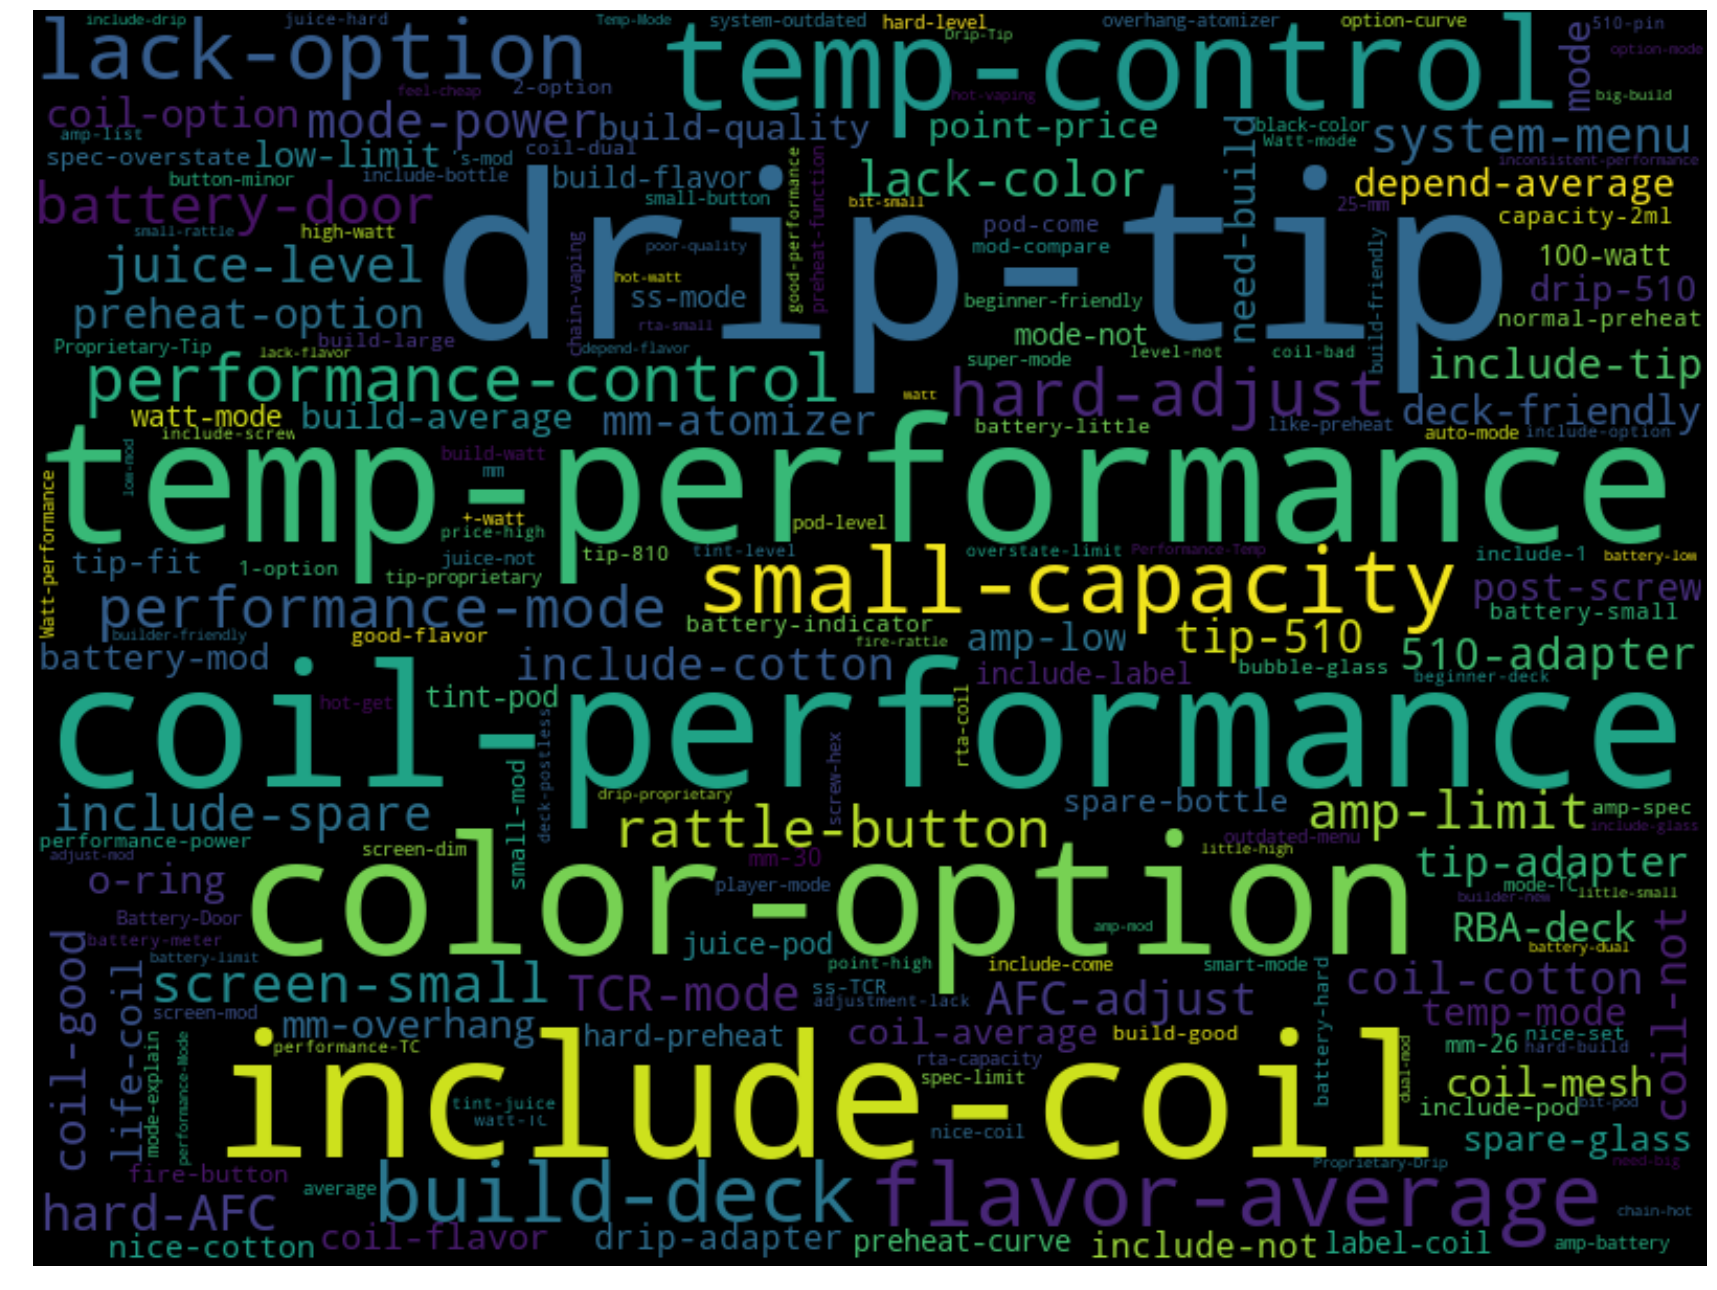

In [17]:
cons_phrases_bi = count_phrases(cons, 2)
create_wordcloud(cons_phrases_bi[0])

In [ ]:
sorted(pros_phrases_bi[0].items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted(cons_phrases_bi[0].items(), key=lambda x: x[1], reverse=True)

Some of the common topics observed are:
* build quality
* drip tip
* price point
* battery
* coil
* colors options
* performance

In [21]:
def get_topic(reviews, keyphrases):
    topic_content = []
    reviews_covered = set()
    for review in reviews:
        statement = review.statement
        for phrase in keyphrases:
            if type(phrase) == tuple:
                if all(word in {w.lemma_ for w in statement} for word in phrase):
                    topic_content.append(review)
                    reviews_covered.add(review.url)
                    break
            else:
                if phrase in {w.lemma_ for w in statement}:
                    topic_content.append(review)
                    reviews_covered.add(review.url)
                    break
    return SimpleNamespace(unique_reviews=reviews_covered, statements=topic_content)

def get_topic_stats(pros, cons, num_reviews, keyphrases):
    topic_pros = get_topic(pros, keyphrases)
    topic_cons = get_topic(cons, keyphrases)
    print('Number of pros matched: %s' % len(topic_pros.statements))
    print('Number of unique reviews matched: %s' % len(topic_pros.unique_reviews))
    print('Prevalence of topic (as pro) among all reviews: %s%% (%s / %s)' % (len(topic_pros.unique_reviews) / num_reviews * 100, len(topic_pros.unique_reviews), num_reviews))
    print('Prevalance of topic among all pros: %s%% (%s / %s)' % (len(topic_pros.statements) / len(pros) * 100, len(topic_pros.statements), len(pros)))
    print('\nNumber of cons: %s' % len(topic_cons.statements))
    print('Number of unique reviews matched: %s' % len(topic_cons.unique_reviews))
    print('Prevalence of topic (as con) among all reviews: %s%% (%s / %s)' % (len(topic_cons.unique_reviews) / num_reviews * 100, len(topic_cons.unique_reviews), num_reviews))
    print('Prevalance of topic among all cons: %s%% (%s / %s)' % (len(topic_cons.statements) / len(cons) * 100, len(topic_cons.statements), len(cons)))
    return SimpleNamespace(pros=topic_pros, cons=topic_cons)

### Product quality
This topic talks about the general quality of the product, or the quality of specific parts.

In [22]:
build_quality = get_topic_stats(pros, cons, NUM_REVIEWS, [('quality')])

Number of pros matched: 146
Number of unique reviews matched: 114
Prevalence of topic (as pro) among all reviews: 45.96774193548387% (114 / 248)
Prevalance of topic among all pros: 4.9846363946739505% (146 / 2929)

Number of cons: 14
Number of unique reviews matched: 13
Prevalence of topic (as con) among all reviews: 5.241935483870968% (13 / 248)
Prevalance of topic among all cons: 1.3958125623130608% (14 / 1003)


The topic can be sub-divided into a number of themes:
The most common theme talks about the overall build quality of the product. The build quality of a product refers to the structural integrity of the device, and/or the quality of material used to build the device.

In [23]:
get_topic_stats(build_quality.pros.statements, build_quality.cons.statements, NUM_REVIEWS, ['build']);

Number of pros matched: 48
Number of unique reviews matched: 45
Prevalence of topic (as pro) among all reviews: 18.14516129032258% (45 / 248)
Prevalance of topic among all pros: 32.87671232876712% (48 / 146)

Number of cons: 9
Number of unique reviews matched: 9
Prevalence of topic (as con) among all reviews: 3.6290322580645165% (9 / 248)
Prevalance of topic among all cons: 64.28571428571429% (9 / 14)


The screw quality also seems to be an important aspect to consider. This topic talks specifically about the screw.

In [24]:
get_topic_stats(build_quality.pros.statements, build_quality.cons.statements, NUM_REVIEWS, ['screw']);

Number of pros matched: 63
Number of unique reviews matched: 61
Prevalence of topic (as pro) among all reviews: 24.596774193548388% (61 / 248)
Prevalance of topic among all pros: 43.15068493150685% (63 / 146)

Number of cons: 4
Number of unique reviews matched: 4
Prevalence of topic (as con) among all reviews: 1.6129032258064515% (4 / 248)
Prevalance of topic among all cons: 28.57142857142857% (4 / 14)


Finally, the tank quality is also talked about, but not very often.

In [25]:
get_topic_stats(build_quality.pros.statements, build_quality.cons.statements, NUM_REVIEWS, ['tank']);

Number of pros matched: 5
Number of unique reviews matched: 5
Prevalence of topic (as pro) among all reviews: 2.0161290322580645% (5 / 248)
Prevalance of topic among all pros: 3.4246575342465753% (5 / 146)

Number of cons: 0
Number of unique reviews matched: 0
Prevalence of topic (as con) among all reviews: 0.0% (0 / 248)
Prevalance of topic among all cons: 0.0% (0 / 14)


### Tip and Pin
This topic talks about the drip tip and pin of the e-cig. Themes discussed include the tip model, quality, etc.

In [26]:
tip_or_pin = get_topic_stats(pros, cons, NUM_REVIEWS, ['tip', 'pin'])

Number of pros matched: 215
Number of unique reviews matched: 144
Prevalence of topic (as pro) among all reviews: 58.06451612903226% (144 / 248)
Prevalance of topic among all pros: 7.340389211334927% (215 / 2929)

Number of cons: 50
Number of unique reviews matched: 45
Prevalence of topic (as con) among all reviews: 18.14516129032258% (45 / 248)
Prevalance of topic among all cons: 4.985044865403789% (50 / 1003)


Most of the pros or cons about the pin, or tip happen to be about the model/size.
It is a pro if the tip follows standard specifications (510, 810), it is a con if it is proprietary.

In [27]:
get_topic_stats(tip_or_pin.pros.statements, tip_or_pin.cons.statements, NUM_REVIEWS, ['standard', '510', '810', 'mm', 'proprietary']);

Number of pros matched: 200
Number of unique reviews matched: 142
Prevalence of topic (as pro) among all reviews: 57.25806451612904% (142 / 248)
Prevalance of topic among all pros: 93.02325581395348% (200 / 215)

Number of cons: 28
Number of unique reviews matched: 28
Prevalence of topic (as con) among all reviews: 11.29032258064516% (28 / 248)
Prevalance of topic among all cons: 56.00000000000001% (28 / 50)


### Price point
This topic talks about the price.

In [28]:
price = get_topic_stats(pros, cons, NUM_REVIEWS, ['price'])

Number of pros matched: 103
Number of unique reviews matched: 100
Prevalence of topic (as pro) among all reviews: 40.32258064516129% (100 / 248)
Prevalance of topic among all pros: 3.516558552406965% (103 / 2929)

Number of cons: 9
Number of unique reviews matched: 9
Prevalence of topic (as con) among all reviews: 3.6290322580645165% (9 / 248)
Prevalance of topic among all cons: 0.897308075772682% (9 / 1003)


In [29]:
import re
def get_all_prices(pros):
    matches = []
    for review in pros:
        matches += re.findall(r'(?:\d+(?:\.|\-)?)?\d+\s*(?:\$|usd|dollar|buck)s?', review.statement.text.lower())
    return Counter(matches)

We can have a look at what prices are good enough to be considered pros. The value after the `:` denotes the number of times the price occured. Eg: `'30 usd': 10` means that the phrase `30 usd` occured in 10 different sentences.

In [30]:
get_all_prices(price.pros.statements)

Counter({'20 usd': 4,
         '30 usd': 11,
         '30 bucks': 15,
         '50 bucks': 3,
         '44 bucks': 1,
         '40-50 bucks': 1,
         '40 bucks': 3,
         '25 bucks': 5,
         '20 dollars': 2,
         '30 dollars': 3,
         '40 dollars': 1,
         '25 dollars': 1,
         '15 dollars': 1,
         '24 bucks': 1,
         '120.00 usd': 1,
         '35 usd': 1,
         '22.99usd': 1,
         '29-40 usd': 1,
         '20-35 usd': 1,
         '27 usd': 1,
         '25-30 bucks': 1,
         '25-35 bucks': 1,
         '25 usd': 2,
         '35 bucks': 2,
         '32 bucks': 1,
         '50usd': 2,
         '25usd': 1,
         '10 usd': 1})

Similary, for the cons.

In [31]:
get_all_prices(price.cons.statements)

Counter({'50 usd': 2, '8 usd': 1})

### Battery

In [32]:
battery = get_topic_stats(pros, cons, NUM_REVIEWS, ['battery', 'batteries'])

Number of pros matched: 150
Number of unique reviews matched: 100
Prevalence of topic (as pro) among all reviews: 40.32258064516129% (100 / 248)
Prevalance of topic among all pros: 5.121201775349949% (150 / 2929)

Number of cons: 63
Number of unique reviews matched: 49
Prevalence of topic (as con) among all reviews: 19.758064516129032% (49 / 248)
Prevalance of topic among all cons: 6.281156530408774% (63 / 1003)


Battery life, quality, and interchangability (compatibility with other batteries) is usually a pro.

In [33]:
get_topic_stats(battery.pros.statements, battery.cons.statements, NUM_REVIEWS, ['life', 'good', 'compatibility', 'decent']);

Number of pros matched: 44
Number of unique reviews matched: 39
Prevalence of topic (as pro) among all reviews: 15.725806451612904% (39 / 248)
Prevalance of topic among all pros: 29.333333333333332% (44 / 150)

Number of cons: 0
Number of unique reviews matched: 0
Prevalence of topic (as con) among all reviews: 0.0% (0 / 248)
Prevalance of topic among all cons: 0.0% (0 / 63)


Damage to the battery, or the size is also talked about. The door quality is also important.

In [34]:
get_topic_stats(battery.pros.statements, battery.cons.statements, NUM_REVIEWS, ['size', 'damage', 'small', 'large', 'big', 'door']);

Number of pros matched: 60
Number of unique reviews matched: 56
Prevalence of topic (as pro) among all reviews: 22.58064516129032% (56 / 248)
Prevalance of topic among all pros: 40.0% (60 / 150)

Number of cons: 27
Number of unique reviews matched: 25
Prevalence of topic (as con) among all reviews: 10.080645161290322% (25 / 248)
Prevalance of topic among all cons: 42.857142857142854% (27 / 63)


The following topics don't have any discernable sub-topics yet.

### Coil

In [35]:
coil = get_topic_stats(pros, cons, NUM_REVIEWS, ['coil'])

Number of pros matched: 100
Number of unique reviews matched: 71
Prevalence of topic (as pro) among all reviews: 28.62903225806452% (71 / 248)
Prevalance of topic among all pros: 3.4141345168999657% (100 / 2929)

Number of cons: 114
Number of unique reviews matched: 80
Prevalence of topic (as con) among all reviews: 32.25806451612903% (80 / 248)
Prevalance of topic among all cons: 11.365902293120637% (114 / 1003)


### Color options

In [36]:
colors = get_topic_stats(pros, cons, NUM_REVIEWS, ['color', 'colors', 'bright', 'blue', 'green', 'amber'])

Number of pros matched: 199
Number of unique reviews matched: 143
Prevalence of topic (as pro) among all reviews: 57.66129032258065% (143 / 248)
Prevalance of topic among all pros: 6.794127688630932% (199 / 2929)

Number of cons: 32
Number of unique reviews matched: 31
Prevalence of topic (as con) among all reviews: 12.5% (31 / 248)
Prevalance of topic among all cons: 3.1904287138584246% (32 / 1003)


### Performance

In [37]:
performance = get_topic_stats(pros, cons, NUM_REVIEWS, ['performance'])

Number of pros matched: 150
Number of unique reviews matched: 103
Prevalence of topic (as pro) among all reviews: 41.53225806451613% (103 / 248)
Prevalance of topic among all pros: 5.121201775349949% (150 / 2929)

Number of cons: 78
Number of unique reviews matched: 68
Prevalence of topic (as con) among all reviews: 27.419354838709676% (68 / 248)
Prevalance of topic among all cons: 7.7766699900299106% (78 / 1003)


The performance talks about the following attributes:
- Coil
- Temp Control
- Watt mode

In [38]:
get_topic_stats(performance.pros.statements, performance.cons.statements, NUM_REVIEWS, ['coil']);

Number of pros matched: 21
Number of unique reviews matched: 21
Prevalence of topic (as pro) among all reviews: 8.46774193548387% (21 / 248)
Prevalance of topic among all pros: 14.000000000000002% (21 / 150)

Number of cons: 24
Number of unique reviews matched: 23
Prevalence of topic (as con) among all reviews: 9.274193548387096% (23 / 248)
Prevalance of topic among all cons: 30.76923076923077% (24 / 78)


In [39]:
get_topic_stats(performance.pros.statements, performance.cons.statements, NUM_REVIEWS, [('temp', 'control'), 'tc']);

Number of pros matched: 8
Number of unique reviews matched: 8
Prevalence of topic (as pro) among all reviews: 3.225806451612903% (8 / 248)
Prevalance of topic among all pros: 5.333333333333334% (8 / 150)

Number of cons: 20
Number of unique reviews matched: 20
Prevalence of topic (as con) among all reviews: 8.064516129032258% (20 / 248)
Prevalance of topic among all cons: 25.64102564102564% (20 / 78)


In [40]:
get_topic_stats(performance.pros.statements, performance.cons.statements, NUM_REVIEWS, [('watt', 'mode'), ('power', 'mode')]);

Number of pros matched: 29
Number of unique reviews matched: 29
Prevalence of topic (as pro) among all reviews: 11.693548387096774% (29 / 248)
Prevalance of topic among all pros: 19.333333333333332% (29 / 150)

Number of cons: 8
Number of unique reviews matched: 8
Prevalence of topic (as con) among all reviews: 3.225806451612903% (8 / 248)
Prevalance of topic among all cons: 10.256410256410255% (8 / 78)


- Anotate numerator, denominator for each percentage
- Give label list for each topic.

## Rough Work

In [54]:
import csv
with open('../data/classifications.csv', 'w', newline='') as csvfile:
    writer =csv.writer(csvfile, delimiter=',')
    writer.writerow(["Topic", "Statement", "Review URL", "Type"])
    for t in ["pros", "cons"]:
        for x in getattr(build_quality, t).statements:
            writer.writerow(["Build Quality", x.statement, x.url, t[:-1]])
        for x in getattr(tip_or_pin, t).statements:
            writer.writerow(["Tip/Pin", x.statement, x.url, t[:-1]])
        for x in getattr(price, t).statements:
            writer.writerow(["Price", x.statement, x.url, t[:-1]])
        for x in getattr(battery, t).statements:
            writer.writerow(["Battery", x.statement, x.url, t[:-1]])
        for x in getattr(coil, t).statements:
            writer.writerow(["Coil", x.statement, x.url, t[:-1]])
        for x in getattr(colors, t).statements:
            writer.writerow(["Colors", x.statement, x.url, t[:-1]])
        for x in getattr(performance, t).statements:
            writer.writerow(["Performance", x.statement, x.url, t[:-1]])

In [47]:
for x in build_quality.pros.statements:
    print(x)
    break

namespace(statement=good build quality on battery, url='https://www.reddit.com/r/electronic_cigarette/comments/9wgzpr/anthony_vapes_hugsvape_surge_pod_review.json')


In [51]:
getattr(build_quality, 'pros')

namespace(statements=[namespace(statement=good build quality on battery, url='https://www.reddit.com/r/electronic_cigarette/comments/9wgzpr/anthony_vapes_hugsvape_surge_pod_review.json'), namespace(statement=good build quality on battery, url='https://www.reddit.com/r/electronic_cigarette/comments/a2rwac/anthony_vapes_havahali_hava_one_pod_system_review.json'), namespace(statement=Nice build quality, url='https://www.reddit.com/r/electronic_cigarette/comments/a1w5kk/anthony_vapes_smoant_naboo_kit_tech_review.json'), namespace(statement=nice solid build quality and no button rattle, url='https://www.reddit.com/r/electronic_cigarette/comments/9xfocn/anthony_vapes_innokin_big_box_atlus_mod_tech.json'), namespace(statement=post screw quality is good, url='https://www.reddit.com/r/electronic_cigarette/comments/9x2zpp/anthony_vapes_digiflavor_etna_mtl_rda_review.json'), namespace(statement=good build quality, url='https://www.reddit.com/r/electronic_cigarette/comments/9x2zpp/anthony_vapes_di